In [1]:
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns  
from linares_plot import *
from datetime import datetime
from linares_plot import *


In [2]:
##Abrir los datos 
## Hacer un dataframe para cada subject en cada truco
## Concatenar esos dataframe (manteniendo información de truco i subject)
## Añadir también una columna con los tiempos (el que estaba y en segundo)

frames=[]
Trucos=['Truco 1', 'Truco 2', 'Truco 3', 'Truco 4', 'Truco 5', 'Truco 6', 'Truco 7', 'Truco 8' ]

for T in Trucos:
    Df=pd.read_excel(os.getcwd() + '\\ANOTACIONES_.xlsx', sheet_name= T )
    subj_idx = Df.columns[2:]
    #   
    for s in subj_idx:
        df_x = Df[['Tiempo_s', 'Tiempo', s]]
        df_x.columns=['time_s', 'time_min_sec', 'labels']
        df_x['subject']=s
        df_x['trick']=int(T.split(' ')[1])
        frames.append(df_x)

Df = pd.concat(frames, ignore_index=True)

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
### Quitar los momentos en que no hay eventos! (Nans fuera)
df_ = Df.loc[~pd.isna(Df['labels'])]
df_.head()
len(df_) 

10302

In [4]:
## Como en ocasiones hay más de una acción en un mismo tiempo, hacer que en la columna label no haya comas
## En el caso que coocurran acciones, "multiplicar la linea", una para cada evento
## Como consecuencia, el len aumentará respecto df_

items=[]

for i in range(len(df_)):
    #print(i)
    n_actions = len(df_.labels.iloc[i].split(','))
    if n_actions==1:
        items.append([df_.time_s.iloc[i], df_.time_min_sec.iloc[i], 
                      df_.labels.iloc[i], df_.subject.iloc[i],  df_.trick.iloc[i]  ])
    elif n_actions>1:
        actions = df_.labels.iloc[i].split(',')
        for a in range(0, n_actions):
            items.append([df_.time_s.iloc[i], df_.time_min_sec.iloc[i], 
                          actions[a], df_.subject.iloc[i],  df_.trick.iloc[i]  ])
            
            
df_actions = pd.DataFrame(items)    
df_actions.columns = ['time_s', 'time_min_sec', 'labels', 'subject', 'trick']
print(len(df_actions))
df_actions.head(10)

14411


,time_s,time_min_sec,labels,subject,trick
0,8,00:00:08,Se,1,1
1,10,00:00:10,B,1,1
2,30,00:00:30,In,1,1
3,110,00:01:50,L,1,1
4,126,00:02:06,B,1,1
5,132,00:02:12,L,1,1
6,140,00:02:20,I,1,1
7,140,00:02:20,S,1,1
8,146,00:02:26,L,1,1
9,156,00:02:36,S,1,1


In [5]:
df_actions.labels.unique()

array(['Se', 'B', 'In', 'L', 'I', ' S', 'S', 'A', 'PERD.VIS', 'AA', 'R',
       'P', 'C', 'D', 'Si', ' R', 'M', 'F', ' F', 'A+', 'O', ' A',
       'PERD. VIS', 'A0', ' A+', 'P ', ' P', 'iN', ' L ', ' Si', 'PV',
       'N', 'a', 'perd.vis', ' C', ' D', ' B', ' Se', ' VP', 'VP', ' I',
       ' PV', ' L', 'H', 'DD', ' AA', 'T', ' a', ' N', ' O', 'AA+', 'se',
       'F ', 'S ', 'IN', 'PV ', 'SS', 'F  ', 'L ', ' I ', 'M  ', ' S   ',
       'N  ', 'sI', 'a?', 'N ', ' F ', ' In', 'VP ', ' L   ', 'S  ',
       ' A (ANTES)', 'TONTO BOCA P', 'L  ', ' A0', ' S ', 'C ', 'X',
       ' C ', '  L', ' R ', ' A ', 'F?', 'aa'], dtype=object)

In [6]:
### Correccion de fallos en las labels al entrar los datos
df_actions['labels'] = df_actions['labels'].replace([' Se'], ['Se'])
df_actions['labels'] = df_actions['labels'].replace(['se'], ['Se'])
df_actions['labels'] = df_actions['labels'].replace([' A'], ['A'])
df_actions['labels'] = df_actions['labels'].replace([' A '], ['A'])
df_actions['labels'] = df_actions['labels'].replace([' B'], ['B'])
df_actions['labels'] = df_actions['labels'].replace([' I'], ['I'])
df_actions['labels'] = df_actions['labels'].replace([' L'], ['L'])
df_actions['labels'] = df_actions['labels'].replace(['  L'], ['L'])
df_actions['labels'] = df_actions['labels'].replace(['L  '], ['L'])
df_actions['labels'] = df_actions['labels'].replace([' L '], ['L'])
df_actions['labels'] = df_actions['labels'].replace(['L '], ['L'])
df_actions['labels'] = df_actions['labels'].replace(['N '], ['N'])
df_actions['labels'] = df_actions['labels'].replace(['N  '], ['N'])
df_actions['labels'] = df_actions['labels'].replace([' N'], ['N'])
df_actions['labels'] = df_actions['labels'].replace([' S'], ['S'])
df_actions['labels'] = df_actions['labels'].replace([' S  '], ['S'])
df_actions['labels'] = df_actions['labels'].replace([' S   '], ['S'])
df_actions['labels'] = df_actions['labels'].replace(['S '], ['S'])
df_actions['labels'] = df_actions['labels'].replace([' S '], ['S'])
df_actions['labels'] = df_actions['labels'].replace(['S  '], ['S'])
df_actions['labels'] = df_actions['labels'].replace(['R '], ['R'])
df_actions['labels'] = df_actions['labels'].replace([' R'], ['R'])
df_actions['labels'] = df_actions['labels'].replace([' R '], ['R'])
df_actions['labels'] = df_actions['labels'].replace(['C '], ['C'])
df_actions['labels'] = df_actions['labels'].replace([' C '], ['C'])
df_actions['labels'] = df_actions['labels'].replace([' C'], ['C'])
df_actions['labels'] = df_actions['labels'].replace(['F '], ['F'])
df_actions['labels'] = df_actions['labels'].replace([' F '], ['F'])
df_actions['labels'] = df_actions['labels'].replace(['F  '], ['F'])
df_actions['labels'] = df_actions['labels'].replace([' F'], ['F'])
df_actions['labels'] = df_actions['labels'].replace(['M '], ['M'])
df_actions['labels'] = df_actions['labels'].replace(['M  '], ['M'])
df_actions['labels'] = df_actions['labels'].replace(['a '], ['a'])
df_actions['labels'] = df_actions['labels'].replace([' a'], ['a'])
df_actions['labels'] = df_actions['labels'].replace([' AA'], ['AA'])
df_actions['labels'] = df_actions['labels'].replace([' A0'], ['A0'])
df_actions['labels'] = df_actions['labels'].replace(['IN'], ['In'])
df_actions['labels'] = df_actions['labels'].replace([' In'], ['In'])
df_actions['labels'] = df_actions['labels'].replace(['iN'], ['In'])
df_actions['labels'] = df_actions['labels'].replace([' D'], ['D'])
df_actions['labels'] = df_actions['labels'].replace([' O'], ['O'])
df_actions['labels'] = df_actions['labels'].replace([' A+'], ['A+'])
df_actions['labels'] = df_actions['labels'].replace([' L   '], ['L'])
df_actions['labels'] = df_actions['labels'].replace([' I '], ['I'])
df_actions['labels'] = df_actions['labels'].replace(['PERD.VIS'], ['PV'])
df_actions['labels'] = df_actions['labels'].replace(['PERD. VIS'], ['PV'])
df_actions['labels'] = df_actions['labels'].replace(['perd.vis'], ['PV'])
df_actions['labels'] = df_actions['labels'].replace(['VP'], ['PV'])
df_actions['labels'] = df_actions['labels'].replace([' VP'], ['PV'])
df_actions['labels'] = df_actions['labels'].replace(['VP '], ['PV'])
df_actions['labels'] = df_actions['labels'].replace(['PV '], ['PV'])
df_actions['labels'] = df_actions['labels'].replace([' PV'], ['PV'])
df_actions['labels'] = df_actions['labels'].replace(['P '], ['P'])
df_actions['labels'] = df_actions['labels'].replace([' P'], ['P'])
df_actions['labels'] = df_actions['labels'].replace([' Si'], ['Si'])
df_actions['labels'] = df_actions['labels'].replace(['sI'], ['Si'])
df_actions['labels'] = df_actions['labels'].replace(['SS'], ['S'])
df_actions['labels'] = df_actions['labels'].replace(['DD'], ['D'])
df_actions['labels'] = df_actions['labels'].replace(['a?'], ['a'])
df_actions['labels'] = df_actions['labels'].replace(['F?'], ['F'])
df_actions['labels'] = df_actions['labels'].replace([' A (ANTES)'], ['A'])



df_actions.labels.unique()

array(['Se', 'B', 'In', 'L', 'I', 'S', 'A', 'PV', 'AA', 'R', 'P', 'C',
       'D', 'Si', 'M', 'F', 'A+', 'O', 'A0', 'N', 'a', 'H', 'T', 'AA+',
       'TONTO BOCA P', 'X', 'aa'], dtype=object)

#### Until clarification, I am excluding P, PV, VP, X, aa, H, T, AA+, TONTO BOCA P

In [7]:
df = df_actions.loc[(df_actions['labels']=='Se') | (df_actions['labels']=='B') | (df_actions['labels']=='In') | 
              (df_actions['labels']=='L') | (df_actions['labels']=='I') | (df_actions['labels']=='S') | 
              (df_actions['labels']=='A') | (df_actions['labels']=='AA') | (df_actions['labels']=='R') |
              (df_actions['labels']=='C') | (df_actions['labels']=='D') | (df_actions['labels']=='Si') |
              (df_actions['labels']=='M') | (df_actions['labels']=='F') | (df_actions['labels']=='A+') | 
              (df_actions['labels']=='O') | (df_actions['labels']=='A0') | (df_actions['labels']=='N') |
              (df_actions['labels']=='a')]

df.labels.unique()

array(['Se', 'B', 'In', 'L', 'I', 'S', 'A', 'AA', 'R', 'C', 'D', 'Si',
       'M', 'F', 'A+', 'O', 'A0', 'N', 'a'], dtype=object)

In [8]:
print(len(df))
df.head(10)

14015


,time_s,time_min_sec,labels,subject,trick
0,8,00:00:08,Se,1,1
1,10,00:00:10,B,1,1
2,30,00:00:30,In,1,1
3,110,00:01:50,L,1,1
4,126,00:02:06,B,1,1
5,132,00:02:12,L,1,1
6,140,00:02:20,I,1,1
7,140,00:02:20,S,1,1
8,146,00:02:26,L,1,1
9,156,00:02:36,S,1,1


In [9]:
### poner a cada acción una relación con los fenómenos del mago según el intervalo en el que ocurre
### poner una duración de la acción? de acuerdo al diccionario

## Para Sincronizar las anotaciones de Jordi y Luis con las de las estudiantes de master, hay que restar a los tiempos de Jordi 
## y Luis 10:31 (10 minutos, 31 segundos) (sincronización de ambos videos)

In [10]:
df_gea=pd.read_excel(os.getcwd() + '\\EVENTOS_GEA.xlsx', sheet_name='Hoja2' )
times_s = [df_gea.tiempo.iloc[i].minute*60 + df_gea.tiempo.iloc[i].second for i in range(len(df_gea))]
df_gea['times_s'] = times_s

### cambiar tiempo y tiempo_s por los corregidos, en los que se restan 10 minutos, 31 segundos. De esta manera, 
### los dos dataframes están sincronizados

new_times=[]
times_s_new=[]

for i in range(len(df_gea)):
    #print(i)
    h = df_gea.tiempo.iloc[i]
    h_t = str(h.hour) + ':' + str(h.minute) + ':' + str(h.second) 
    substracting = '00:10:31'
    new_time = datetime.strptime(h_t, "%H:%M:%S") - datetime.strptime(substracting, "%H:%M:%S")
    new_times.append(new_time)
    ##
    times_s_new.append(df_gea.times_s.loc[i] - (60*10 + 31) ) 

    
df_gea['tiempo'] = new_times 
df_gea['times_s'] = times_s_new 

df_gea = df_gea.sort_values(by=['times_s'])

df_gea= df_gea.reset_index()
df_gea = df_gea[['tiempo', 'evento', 'decripcion', 'times_s']]
#df_gea.loc[50:100]

In [11]:
window = 5 # max reaction time expected to have "casual" relation? 

In [12]:
event_associated=[]

first_event_time=df_gea['times_s'].iloc[0]

for i in range(len(df)): #len(df)
    time_label = df.time_s.iloc[i]
    if time_label<first_event_time:
        event_associated.append('undetermined')
    else:
        time_previous_event = df_gea.loc[df_gea['times_s'] < time_label ].iloc[-1].times_s
        previous_event = df_gea.loc[df_gea['times_s'] < time_label ].iloc[-1].evento
        if (time_previous_event + window) >= time_label:
            event_associated.append(previous_event)
        else:
            event_associated.append('undetermined')
            
            
            
df['event_associated']=event_associated    
    

C:\Users\David\Anaconda3\envs\python3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
df.head(10)

,time_s,time_min_sec,labels,subject,trick,event_associated
0,8,00:00:08,Se,1,1,undetermined
1,10,00:00:10,B,1,1,undetermined
2,30,00:00:30,In,1,1,gag
3,110,00:01:50,L,1,1,undetermined
4,126,00:02:06,B,1,1,undetermined
5,132,00:02:12,L,1,1,undetermined
6,140,00:02:20,I,1,1,undetermined
7,140,00:02:20,S,1,1,undetermined
8,146,00:02:26,L,1,1,gag
9,156,00:02:36,S,1,1,undetermined


In [14]:
df.event_associated.unique()

array(['undetermined', 'gag', 'Miniclimax', 'Climax final', 'inicio'],
      dtype=object)

In [15]:
df_inicio=df.loc[df['event_associated']=='inicio']
df_gags=df.loc[df['event_associated']=='gag']
df_climax=df.loc[(df['event_associated']=='Miniclimax') | (df['event_associated']=='Climax final') ]

print(len(df_gags))
print(len(df_inicio))
print(len(df_climax))

2711
139
2667


In [16]:
frames=[]

for S in df_gags.subject.unique():
    df_s=df_gags.loc[df_gags['subject']==S]
    df_count = df_s.groupby(['labels']).size().reset_index(name='count')
    df_count['subject']= S
    df_count['event']='gag'
    frames.append(df_count)


for S in df_climax.subject.unique():
    df_s=df_climax.loc[df_climax['subject']==S]
    df_count = df_s.groupby(['labels']).size().reset_index(name='count')
    df_count['subject']= S
    df_count['event']='climax'
    frames.append(df_count)
    
    
df_ = pd.concat(frames)


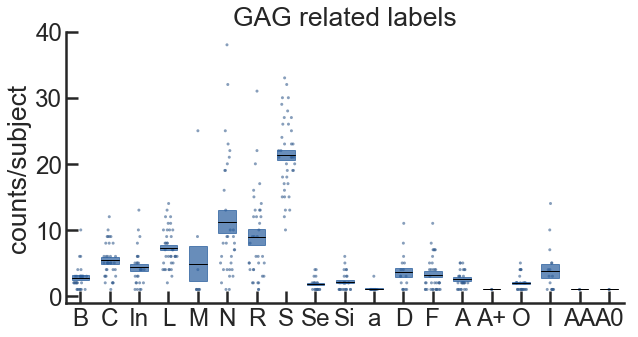

In [17]:
plt.figure(figsize=(10,5))

linares_plot(x='labels', y='count', order=df_.labels.unique(), 
            df=df_.loc[ (df_['event']=='gag') ] , 
            palette=['#285d9d'], CI=0.68,  fill_box=True, by_subj=True, subj_col='subject', 
             reps=100, alpha_box=0.7, alpha=0.6,  point_size=3, leg=True, sep_axis=False)

plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.xlabel('')
#plt.plot([-0.5,2.5], [0,0], 'k--', linewidth=2)
plt.ylabel('counts/subject')
#plt.gca().set_ylim(0,40)
#plt.gca().set_yticks([0,20,40])
plt.title('GAG related labels');

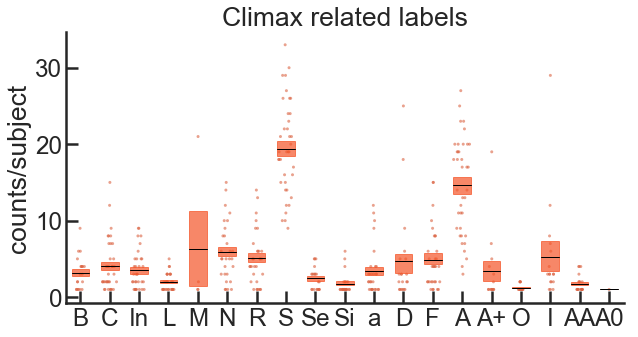

In [18]:
plt.figure(figsize=(10,5))

linares_plot(x='labels', y='count', order=df_.labels.unique(), 
            df=df_.loc[ (df_['event']=='climax') ] , 
            palette=['#f55528'], CI=0.68,  fill_box=True, by_subj=True, subj_col='subject', 
             reps=100, alpha_box=0.7, alpha=0.6,  point_size=3, leg=True, sep_axis=False)

plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.xlabel('')
#plt.plot([-0.5,2.5], [0,0], 'k--', linewidth=2)
plt.ylabel('counts/subject')
#plt.gca().set_ylim(0,40)
#plt.gca().set_yticks([0,20,40])
plt.title('Climax related labels');

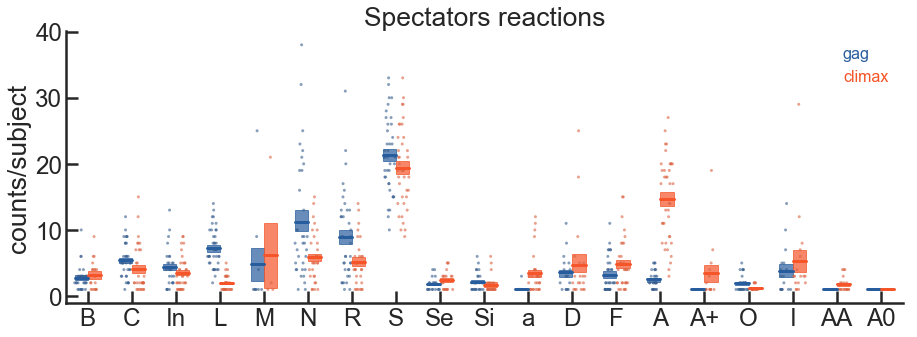

In [19]:
plt.figure(figsize=(15,5))

linares_plot(x='labels', y='count', order=df_.labels.unique(), 
             hue='event', hue_order=['gag', 'climax'], 
             df=df_, palette=['#285d9d', '#f55528'], 
             CI=0.68,  fill_box=True, by_subj=True, subj_col='subject', 
             reps=100, alpha_box=0.7, alpha=0.6,  point_size=3, leg=True, sep_axis=False)

plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.xlabel('')
#plt.plot([-0.5,2.5], [0,0], 'k--', linewidth=2)
plt.ylabel('counts/subject')
#plt.gca().set_ylim(0,40)
#plt.gca().set_yticks([0,20,40])
plt.title('Spectators reactions');

In [86]:
t1_r = df.loc[(df['trick']==1) & (df['labels']=='R')]
t1_r =t1_r.sort_values('time_s')
t1_r['val']=1

xs = np.arange(t1_r.time_s.min(), t1_r.time_s.max()+2,2)
nothing=[]
for t in xs:
    if t not in t1_r.time_s.unique():
        nothing.append([t, t, 'R', 'no', 1, 'nothing', 0])
        
df_nothing = pd.DataFrame(nothing)
df_nothing.columns=t1_r.columns
t1_r = pd.concat([t1_r, df_nothing])

####

t1_s = df.loc[(df['trick']==1) & (df['labels']=='S')]
t1_s =t1_s.sort_values('time_s')
t1_s['val']=1

xs = np.arange(t1_s.time_s.min(), t1_s.time_s.max()+2,2)
nothing=[]
for t in xs:
    if t not in t1_s.time_s.unique():
        nothing.append([t, t, 'S', 'no', 1, 'nothing', 0])
        
df_nothing = pd.DataFrame(nothing)
df_nothing.columns=t1_s.columns
t1_s = pd.concat([t1_s, df_nothing])


C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'trick 1')

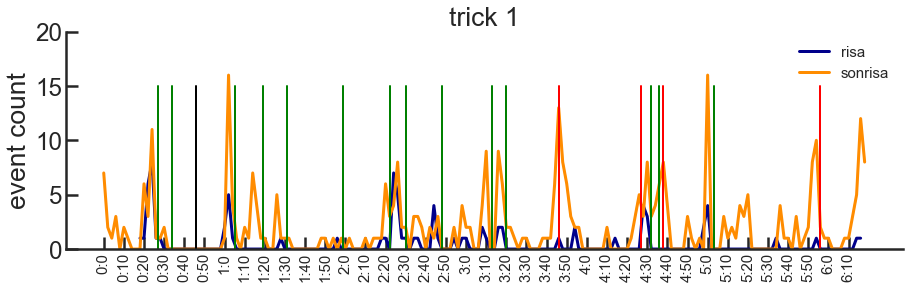

In [147]:
plt.figure(figsize=(15,4))   
sns.lineplot(x='time_s', y='val', data=t1_r, color='darkblue', estimator=np.sum, linewidth=3)
sns.lineplot(x='time_s', y='val', data=t1_s, color='darkorange', estimator=np.sum, linewidth=3)

tim_mi = min(t1_s.time_s.min(), t1_r.time_s.min())
tim_mx = max(t1_s.time_s.max(), t1_r.time_s.max())
events_trick = df_gea.loc[(df_gea['times_s']>tim_mi) & (df_gea['times_s']<tim_mx)]
for i in range(len(events_trick)):
    time_event = events_trick.iloc[i].times_s
    nature_event = events_trick.iloc[i].evento
    if nature_event == 'gag':        
        plt.plot([time_event, time_event], [0, 15], color='green', linewidth=2 )
    elif nature_event == 'inicio':        
        plt.plot([time_event, time_event], [0, 15], color='black', linewidth=2 )
    elif nature_event == 'Miniclimax':        
        plt.plot([time_event, time_event], [0, 15], color='red', linewidth=2 )
    elif nature_event == 'Climax final':        
        plt.plot([time_event, time_event], [0, 15], color='red', linewidth=2 )
    else:
        pass

plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)  
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction


x_ticks = list(np.arange(tim_mi, tim_mx, 10) )
times_x = np.array(x_ticks)
t_m = times_x/60

strings_time=[]
for T in t_m:
    minute = int(T)
    sec = int(round((T - minute) * 60 ))
    str_time = str(minute) + ':' + str(sec)
    strings_time.append(str_time)



plt.gca().set_xticks(x_ticks);
plt.gca().set_xticklabels(strings_time, rotation=90, fontsize=15);
plt.ylabel('event count')
plt.xlabel('')
plt.ylim(0,20)

plt.plot([20,21], [100,102], 'darkblue', label='risa')
plt.plot([20,21], [100,102], 'darkorange', label='sonrisa')
plt.legend(frameon=False, prop={'size': 15})
plt.title('trick 1')



C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


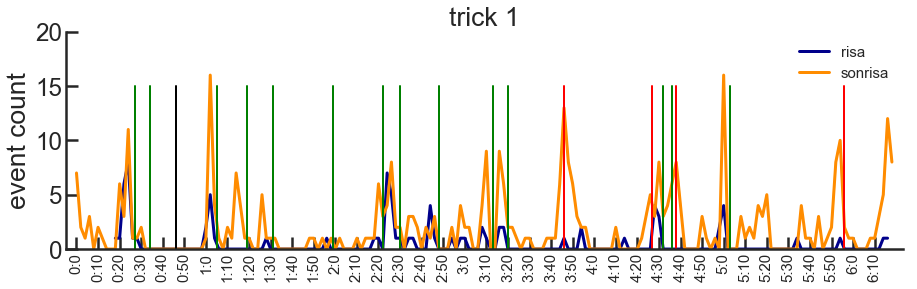

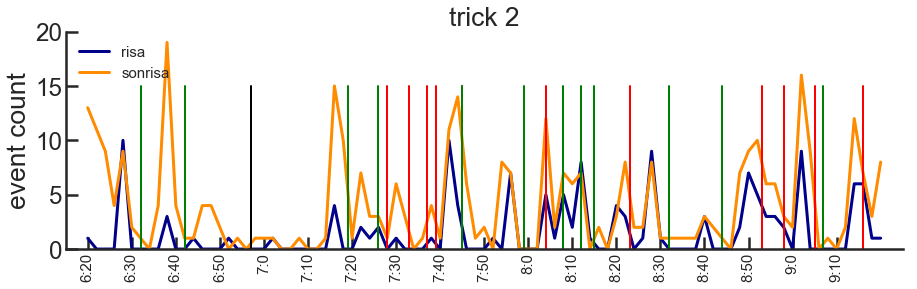

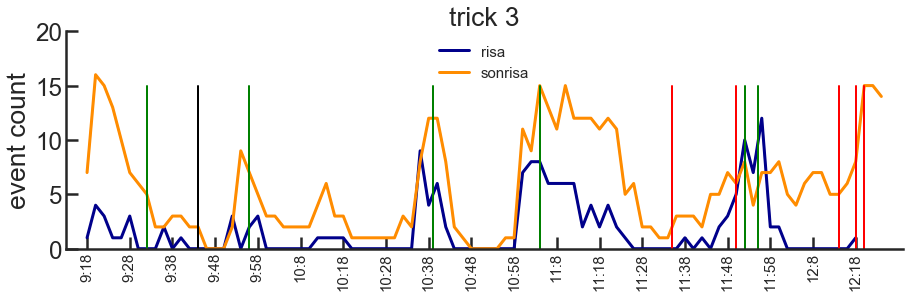

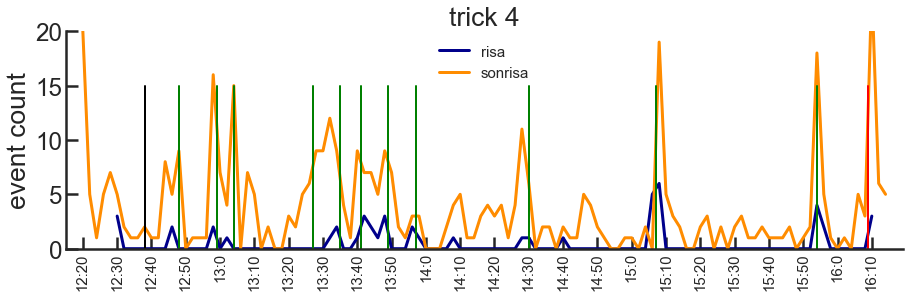

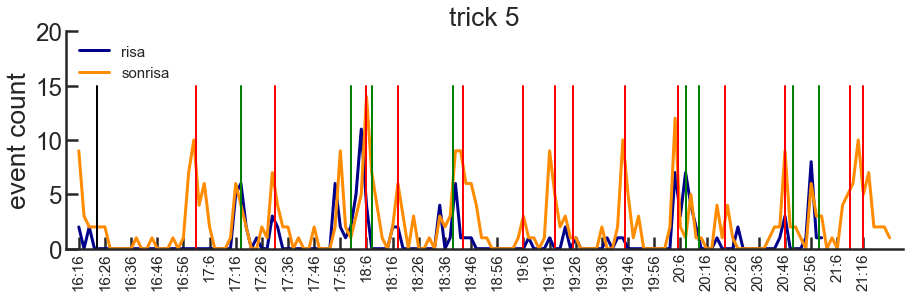

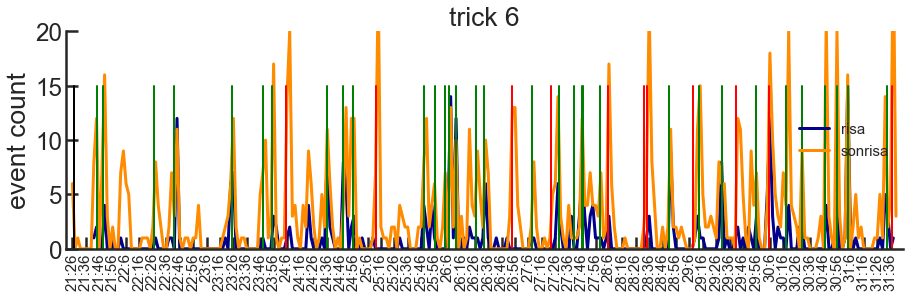

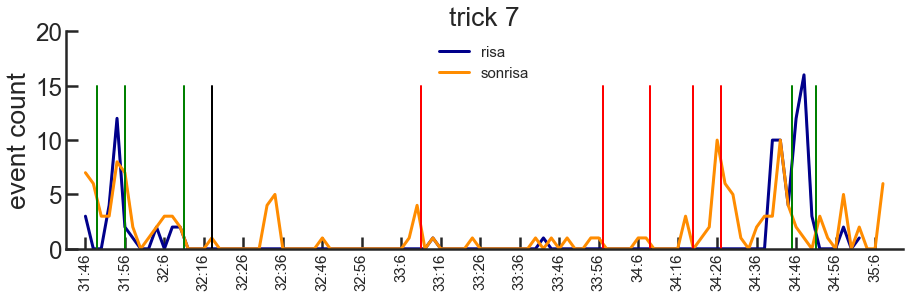

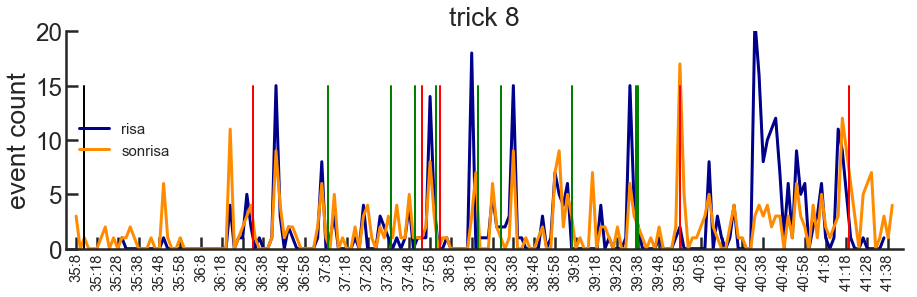

In [151]:

for trick in [1,2,3,4,5,6,7,8]:
    t1_r = df.loc[(df['trick']==trick) & (df['labels']=='R')]
    t1_r =t1_r.sort_values('time_s')
    t1_r['val']=1

    xs = np.arange(t1_r.time_s.min(), t1_r.time_s.max()+2,2)
    nothing=[]
    for t in xs:
        if t not in t1_r.time_s.unique():
            nothing.append([t, t, 'R', 'no', trick, 'nothing', 0])

    df_nothing = pd.DataFrame(nothing)
    df_nothing.columns=t1_r.columns
    t1_r = pd.concat([t1_r, df_nothing])

    ####

    t1_s = df.loc[(df['trick']==trick) & (df['labels']=='S')]
    t1_s =t1_s.sort_values('time_s')
    t1_s['val']=1

    xs = np.arange(t1_s.time_s.min(), t1_s.time_s.max()+2,2)
    nothing=[]
    for t in xs:
        if t not in t1_s.time_s.unique():
            nothing.append([t, t, 'S', 'no', trick, 'nothing', 0])

    df_nothing = pd.DataFrame(nothing)
    df_nothing.columns=t1_s.columns
    t1_s = pd.concat([t1_s, df_nothing])


    ##############


    plt.figure(figsize=(15,4))   
    sns.lineplot(x='time_s', y='val', data=t1_r, color='darkblue', estimator=np.sum, linewidth=3)
    sns.lineplot(x='time_s', y='val', data=t1_s, color='darkorange', estimator=np.sum, linewidth=3)

    tim_mi = min(t1_s.time_s.min(), t1_r.time_s.min())
    tim_mx = max(t1_s.time_s.max(), t1_r.time_s.max())
    events_trick = df_gea.loc[(df_gea['times_s']>tim_mi) & (df_gea['times_s']<tim_mx)]
    for i in range(len(events_trick)):
        time_event = events_trick.iloc[i].times_s
        nature_event = events_trick.iloc[i].evento
        if nature_event == 'gag':        
            plt.plot([time_event, time_event], [0, 15], color='green', linewidth=2 )
        elif nature_event == 'inicio':        
            plt.plot([time_event, time_event], [0, 15], color='black', linewidth=2 )
        elif nature_event == 'Miniclimax':        
            plt.plot([time_event, time_event], [0, 15], color='red', linewidth=2 )
        elif nature_event == 'Climax final':        
            plt.plot([time_event, time_event], [0, 15], color='red', linewidth=2 )
        else:
            pass

    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)  
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction


    x_ticks = list(np.arange(tim_mi, tim_mx, 10) )
    times_x = np.array(x_ticks)
    t_m = times_x/60

    strings_time=[]
    for T in t_m:
        minute = int(T)
        sec = int(round((T - minute) * 60 ))
        str_time = str(minute) + ':' + str(sec)
        strings_time.append(str_time)



    plt.xlim(tim_mi-5, tim_mx+5)
    plt.gca().set_xticks(x_ticks);
    plt.gca().set_xticklabels(strings_time, rotation=90, fontsize=15);
    plt.ylabel('event count')
    plt.xlabel('')
    plt.ylim(0,20)

    plt.plot([20,21], [100,102], 'darkblue', label='risa')
    plt.plot([20,21], [100,102], 'darkorange', label='sonrisa')
    plt.legend(frameon=False, prop={'size': 15})
    plt.title('trick ' + str(trick))
    plt.show()







C:\Users\David\Anaconda3\envs\python3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


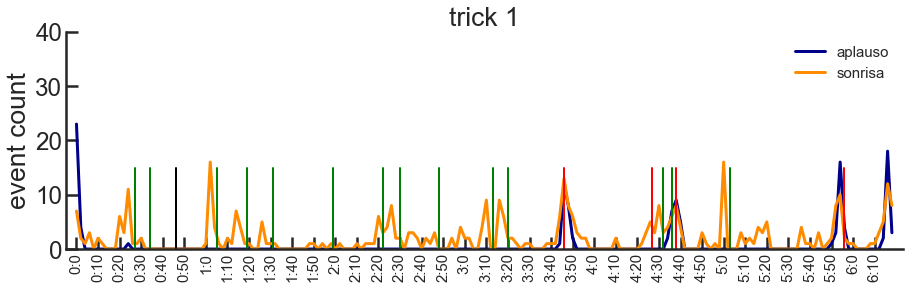

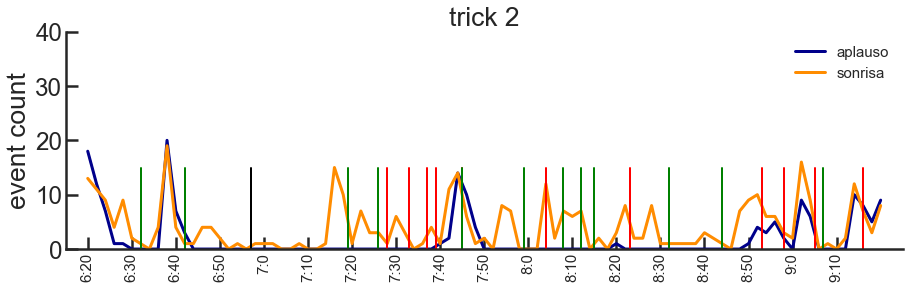

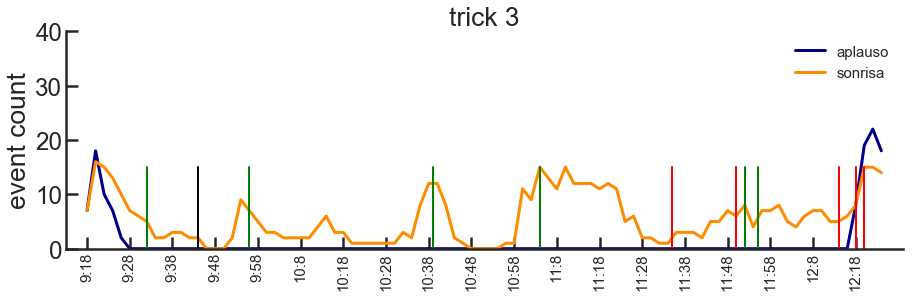

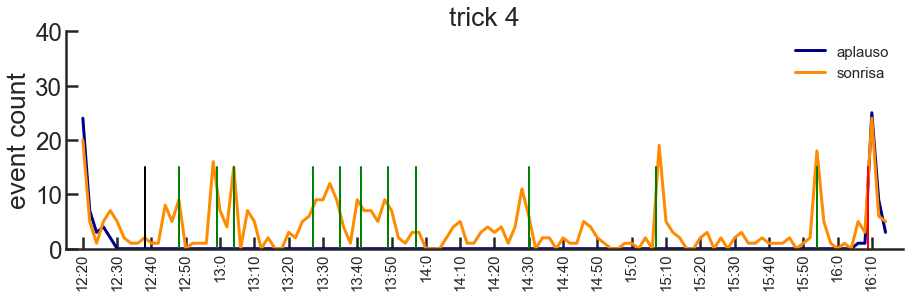

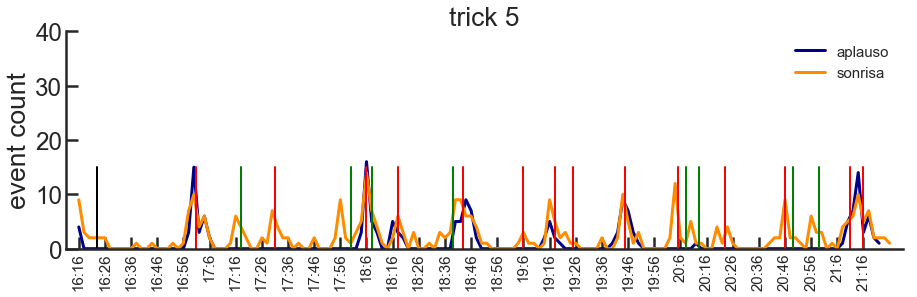

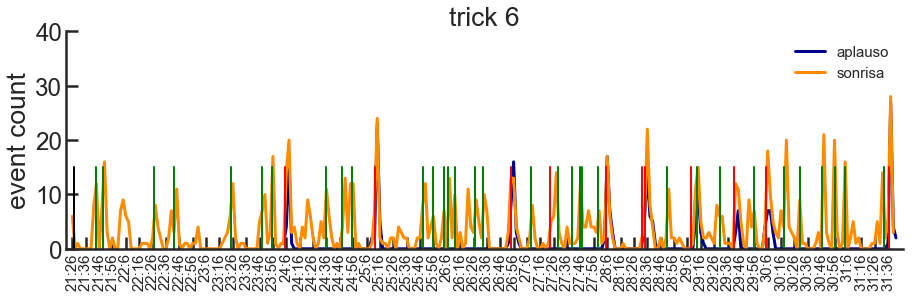

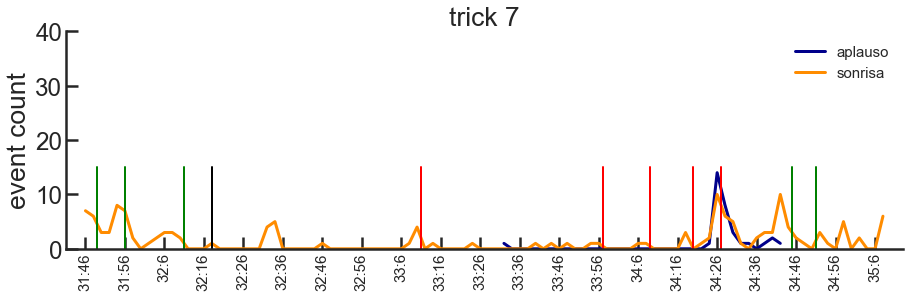

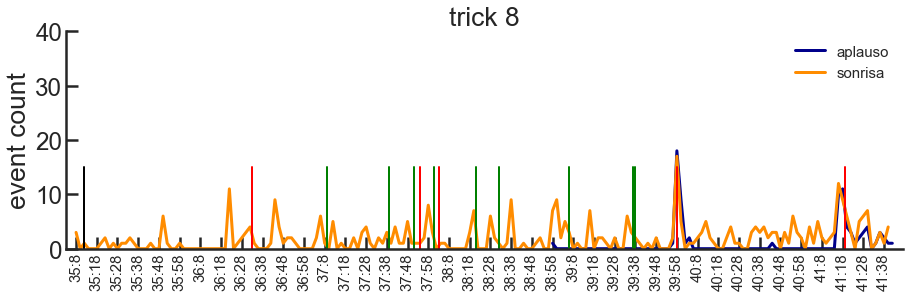

In [153]:

for trick in [1,2,3,4,5,6,7,8]:
    t1_r = df.loc[(df['trick']==trick) & (df['labels']=='A')]
    t1_r =t1_r.sort_values('time_s')
    t1_r['val']=1

    xs = np.arange(t1_r.time_s.min(), t1_r.time_s.max()+2,2)
    nothing=[]
    for t in xs:
        if t not in t1_r.time_s.unique():
            nothing.append([t, t, 'A', 'no', trick, 'nothing', 0])

    df_nothing = pd.DataFrame(nothing)
    df_nothing.columns=t1_r.columns
    t1_r = pd.concat([t1_r, df_nothing])

    ####

    t1_s = df.loc[(df['trick']==trick) & (df['labels']=='S')]
    t1_s =t1_s.sort_values('time_s')
    t1_s['val']=1

    xs = np.arange(t1_s.time_s.min(), t1_s.time_s.max()+2,2)
    nothing=[]
    for t in xs:
        if t not in t1_s.time_s.unique():
            nothing.append([t, t, 'S', 'no', trick, 'nothing', 0])

    df_nothing = pd.DataFrame(nothing)
    df_nothing.columns=t1_s.columns
    t1_s = pd.concat([t1_s, df_nothing])


    ##############


    plt.figure(figsize=(15,4))   
    sns.lineplot(x='time_s', y='val', data=t1_r, color='darkblue', estimator=np.sum, linewidth=3)
    sns.lineplot(x='time_s', y='val', data=t1_s, color='darkorange', estimator=np.sum, linewidth=3)

    tim_mi = min(t1_s.time_s.min(), t1_r.time_s.min())
    tim_mx = max(t1_s.time_s.max(), t1_r.time_s.max())
    events_trick = df_gea.loc[(df_gea['times_s']>tim_mi) & (df_gea['times_s']<tim_mx)]
    for i in range(len(events_trick)):
        time_event = events_trick.iloc[i].times_s
        nature_event = events_trick.iloc[i].evento
        if nature_event == 'gag':        
            plt.plot([time_event, time_event], [0, 15], color='green', linewidth=2 )
        elif nature_event == 'inicio':        
            plt.plot([time_event, time_event], [0, 15], color='black', linewidth=2 )
        elif nature_event == 'Miniclimax':        
            plt.plot([time_event, time_event], [0, 15], color='red', linewidth=2 )
        elif nature_event == 'Climax final':        
            plt.plot([time_event, time_event], [0, 15], color='red', linewidth=2 )
        else:
            pass

    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)  
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction


    x_ticks = list(np.arange(tim_mi, tim_mx, 10) )
    times_x = np.array(x_ticks)
    t_m = times_x/60

    strings_time=[]
    for T in t_m:
        minute = int(T)
        sec = int(round((T - minute) * 60 ))
        str_time = str(minute) + ':' + str(sec)
        strings_time.append(str_time)



    plt.xlim(tim_mi-5, tim_mx+5)
    plt.gca().set_xticks(x_ticks);
    plt.gca().set_xticklabels(strings_time, rotation=90, fontsize=15);
    plt.ylabel('event count')
    plt.xlabel('')
    plt.ylim(0,40)

    plt.plot([20,21], [100,102], 'darkblue', label='aplauso')
    plt.plot([20,21], [100,102], 'darkorange', label='sonrisa')
    plt.legend(frameon=False, prop={'size': 15})
    plt.title('trick ' + str(trick))
    plt.show()






In [97]:
plt.gca().set_xticks()

,time_s,time_min_sec,labels,subject,trick,event_associated,val
243,18,00:00:18,R,7,1,undetermined,1
193,20,00:00:20,R,6,1,undetermined,1
588,22,00:00:22,R,14,1,undetermined,1
1479,22,00:00:22,R,32,1,undetermined,1
897,22,00:00:22,R,22,1,undetermined,1
748,22,00:00:22,R,19,1,undetermined,1
1645,22,00:00:22,R,35,1,undetermined,1
540,22,00:00:22,R,13,1,undetermined,1
780,24,00:00:24,R,20,1,undetermined,1
650,24,00:00:24,R,16,1,undetermined,1


In [91]:
tim_mi = min(t1_s.time_s.min(), t1_r.time_s.min())
tim_mx = max(t1_s.time_s.max(), t1_r.time_s.max())

In [94]:
tim_mi = min(t1_s.time_s.min(), t1_r.time_s.min())
tim_mx = max(t1_s.time_s.max(), t1_r.time_s.max())
events_trick = df_gea.loc[(df_gea['times_s']>tim_mi) & (df_gea['times_s']<tim_mx)]
for i in range(len(events_trick)):
    time_event = events_trick.iloc[i].times_s
    nature_event = events_trick.iloc[i].evento
    if nature_event == 'gag':        
        plt.plot([time_event, time_event], [0, 10], color='red', linewidth=2 )
    elif nature_event == 'inicio':        
        plt.plot([time_event, time_event], [0, 10], color='black', linewidth=2 )
    elif nature_event == 'Miniclimax':        
        plt.plot([time_event, time_event], [0, 10], color='blue', linewidth=2 )
    elif nature_event == 'Climax final':        
        plt.plot([time_event, time_event], [0, 10], color='green', linewidth=2 )
    else:
        print(nature_event)

gag
gag
inicio
gag
gag
gag
gag
gag
gag
gag
gag
gag
Miniclimax
Maniobra
Miniclimax
gag
gag
Miniclimax
gag
Climax final


In [87]:
df_gea

,tiempo,evento,decripcion,times_s
0,00:00:27,gag,broma sobre su dominio del catalán,27
1,00:00:34,gag,"""Por deferencia""",34
2,00:00:46,inicio,Abre el estuche de la baraja,46
3,00:01:05,gag,"""Que haya público""",65
4,00:01:19,gag,"""El público de schroedinger""",79
5,00:01:31,gag,El juego es muy bonito,91
6,00:01:59,gag,"No hay humor, la gente se cambia de sitio",119
7,00:02:22,gag,"Broma: ""Ah! No se puede cambiar""",142
8,00:02:30,gag,"""Como veis soy una persona…""",150
9,00:02:48,gag,"""Preocupado por el ritmo…""",168


In [20]:
frames_trick=[]

for S in df_gags.subject.unique():
    df_s=df_gags.loc[df_gags['subject']==S]
    for T in df_s.trick.unique():
        df_t = df_s.loc[df_s['trick']==T]
        df_count = df_t.groupby(['labels']).size().reset_index(name='count')
        df_count['subject']= S
        df_count['trick']= T
        df_count['event']='gag'
        frames_trick.append(df_count)


for S in df_climax.subject.unique():
    df_s=df_climax.loc[df_climax['subject']==S]
    for T in df_s.trick.unique():
        df_t = df_s.loc[df_s['trick']==T]
        df_count = df_t.groupby(['labels']).size().reset_index(name='count')
        df_count['subject']= S
        df_count['trick']= T
        df_count['event']='climax'
        frames_trick.append(df_count)
    
    
df__ = pd.concat(frames_trick)
df__.head()

,labels,count,subject,trick,event
0,B,2,1,1,gag
1,In,1,1,1,gag
2,L,1,1,1,gag
0,In,1,1,2,gag
1,N,1,1,2,gag


<Figure size 1080x360 with 0 Axes>

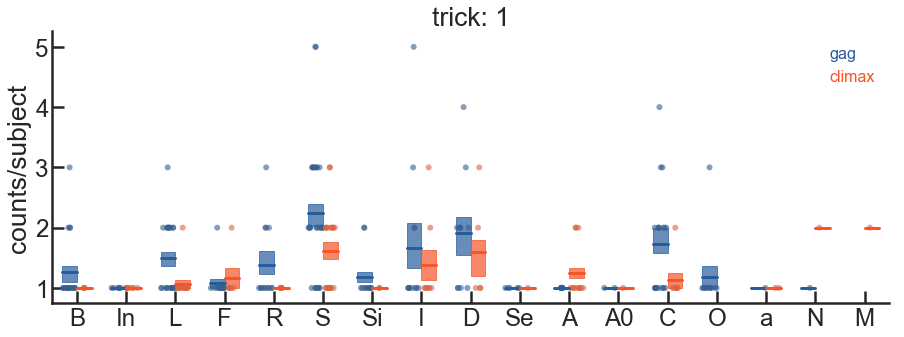

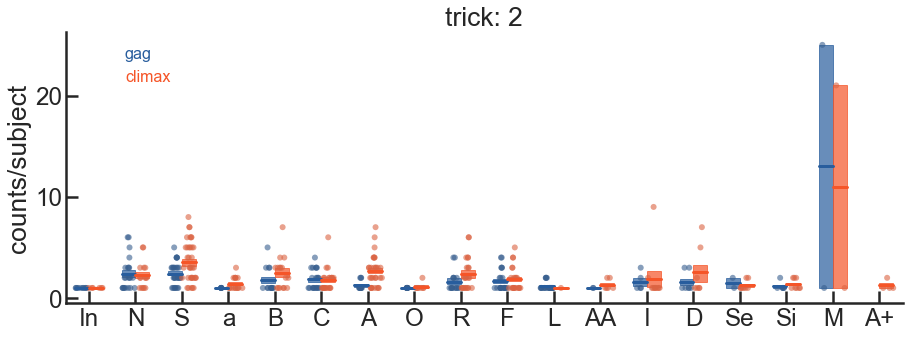

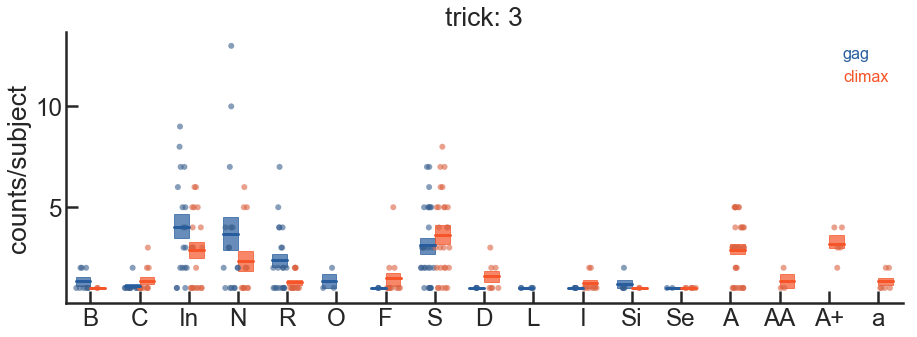

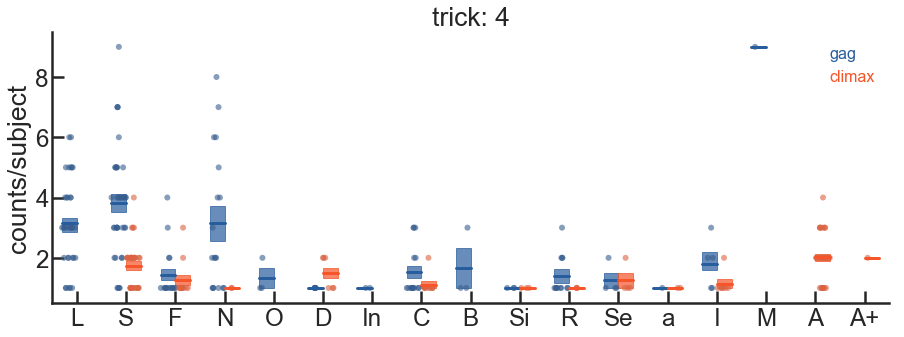

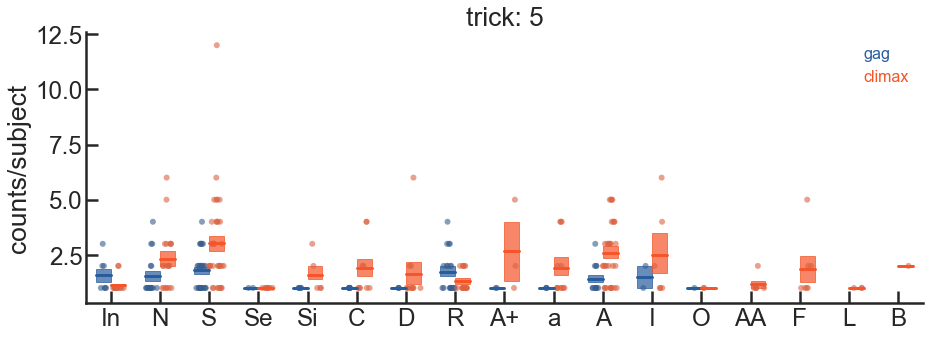

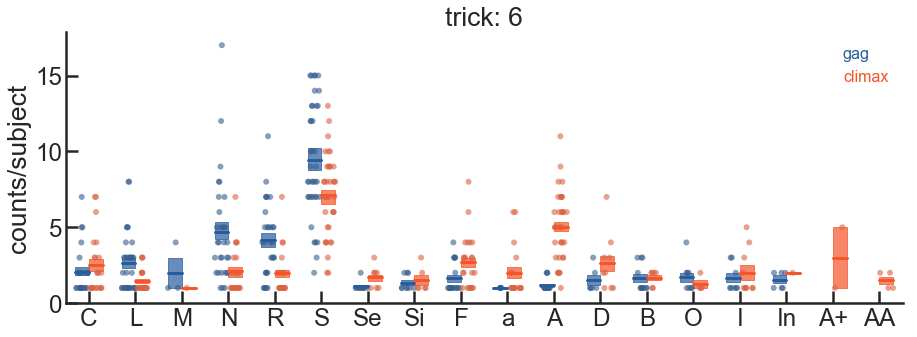

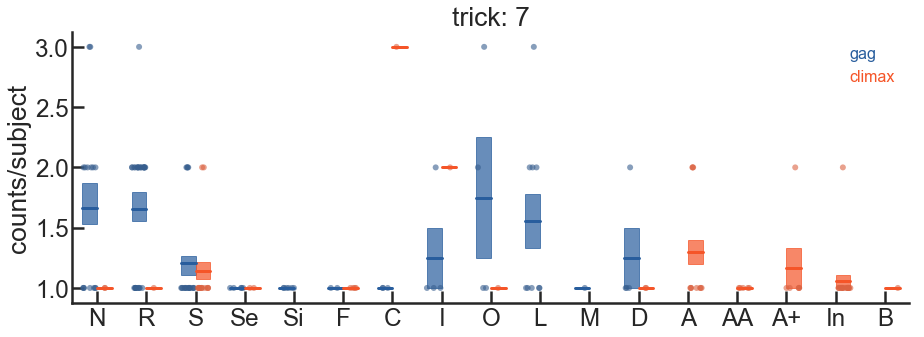

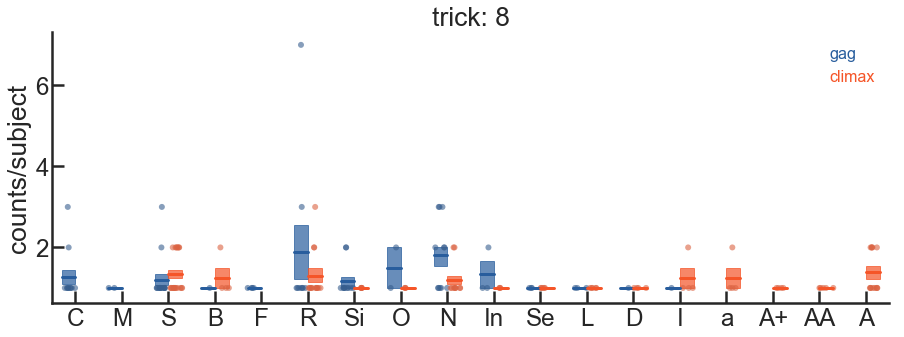

In [21]:
plt.figure(figsize=(15,5))

for trick in range(1,9):
    plt.figure(figsize=(15,5))
    df_tx = df__.loc[df__['trick']==trick]
    linares_plot(x='labels', y='count', order=df_tx.labels.unique(), 
                 hue='event', hue_order=['gag', 'climax'], 
                 df=df_tx, palette=['#285d9d', '#f55528'], 
                 CI=0.68,  fill_box=True, by_subj=True, subj_col='subject', 
                 reps=100, alpha_box=0.7, alpha=0.6,  point_size=6, leg=True, sep_axis=False)

    plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
    plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
    plt.gca().get_xaxis().tick_bottom()                                                                                         
    plt.gca().get_yaxis().tick_left()
    plt.gca().tick_params(direction='in') #direction
    plt.xlabel('')
    #plt.plot([-0.5,2.5], [0,0], 'k--', linewidth=2)
    plt.ylabel('counts/subject')
    #plt.gca().set_ylim(0,40)
    #plt.gca().set_yticks([0,20,40])
    plt.title('trick: ' + str(trick));
    plt.show()
    print('')
    print('')

In [22]:
df__.head()

,labels,count,subject,trick,event
0,B,2,1,1,gag
1,In,1,1,1,gag
2,L,1,1,1,gag
0,In,1,1,2,gag
1,N,1,1,2,gag


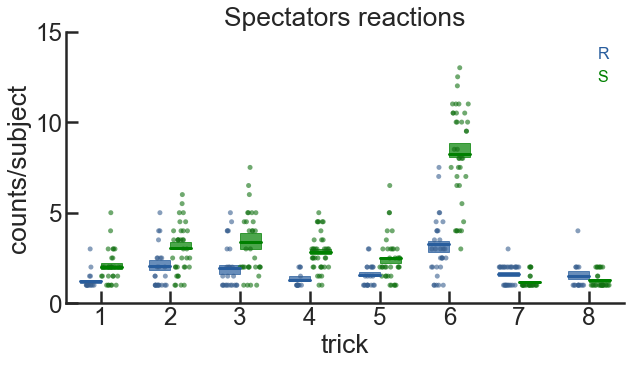

In [23]:
df_RS = df__.loc[(df__['labels']=='R') | (df__['labels']=='S')]

plt.figure(figsize=(10,5))

linares_plot(x='trick', y='count', order=[1,2,3,4,5,6,7,8], 
             hue='labels', hue_order=['R', 'S'], 
             df=df_RS, palette=['#285d9d', 'green'], 
             CI=0.68,  fill_box=True, by_subj=True, subj_col='subject', 
             reps=10, alpha_box=0.7, alpha=0.6,  point_size=5, leg=True, sep_axis=False)

plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.xlabel('trick')
#plt.plot([-0.5,2.5], [0,0], 'k--', linewidth=2)
plt.ylabel('counts/subject')
plt.gca().set_ylim(0,15)
plt.gca().set_yticks([0,5,10,15])
plt.title('Spectators reactions');

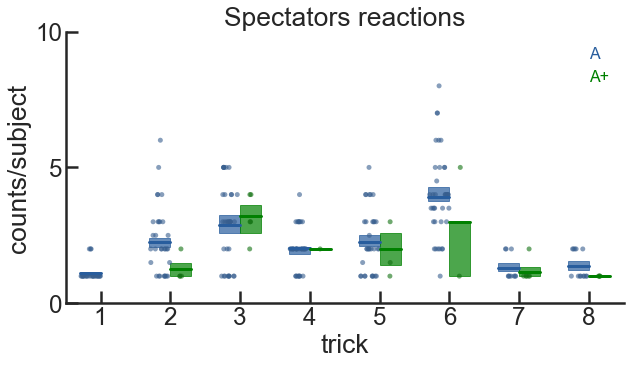

In [24]:
df_AA = df__.loc[(df__['labels']=='A') | (df__['labels']=='A+')]

plt.figure(figsize=(10,5))

linares_plot(x='trick', y='count', order=[1,2,3,4,5,6,7,8], 
             hue='labels', hue_order=['A', 'A+'], 
             df=df_AA, palette=['#285d9d', 'green'], 
             CI=0.68,  fill_box=True, by_subj=True, subj_col='subject', 
             reps=10, alpha_box=0.7, alpha=0.6,  point_size=5, leg=True, sep_axis=False)

plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.xlabel('trick')
#plt.plot([-0.5,2.5], [0,0], 'k--', linewidth=2)
plt.ylabel('counts/subject')
plt.gca().set_ylim(0,10)
plt.gca().set_yticks([0,5,10])
plt.title('Spectators reactions');

Text(0.5,1,'humour related labels')

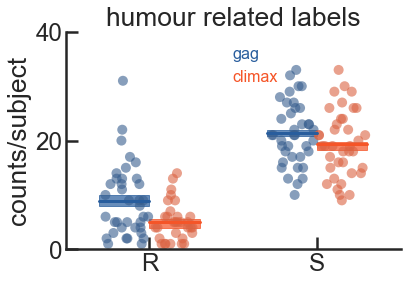

In [25]:
linares_plot(x='labels', y='count', hue='event', order=['R', 'S'], hue_order=['gag', 'climax'],
            df=df_.loc[ (df_['labels']=='S') | (df_['labels']=='R')] , 
            palette=['#285d9d', '#f55528'], CI=0.68,  fill_box=True, by_subj=True, subj_col='subject', 
             reps=10, alpha_box=0.7, alpha=0.6,  point_size=10, leg=True, sep_axis=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.xlabel('')
#plt.plot([-0.5,2.5], [0,0], 'k--', linewidth=2)
plt.ylabel('counts/subject')
plt.gca().set_ylim(0,40)
plt.gca().set_yticks([0,20,40])
plt.title('humour related labels')

Text(0.5,1,'surprise related labels')

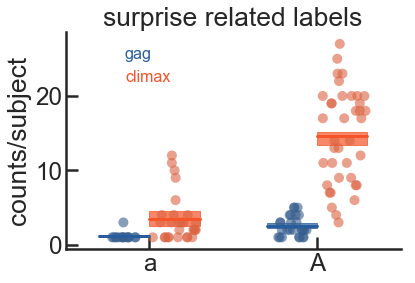

In [26]:
linares_plot(x='labels', y='count', hue='event', order=['a', 'A'], hue_order=['gag', 'climax'],
            df=df_.loc[ (df_['labels']=='a') | (df_['labels']=='A')] , 
            palette=['#285d9d', '#f55528'], CI=0.68,  fill_box=True, by_subj=True, subj_col='subject', 
             reps=10, alpha_box=0.7, alpha=0.6,  point_size=10, leg=True, sep_axis=False)
plt.gca().spines['right'].set_visible(False)  # aesthetics                                                                              # remove right spines
plt.gca().spines['top'].set_visible(False)                                                                                  # remove top spines
plt.gca().get_xaxis().tick_bottom()                                                                                         
plt.gca().get_yaxis().tick_left()
plt.gca().tick_params(direction='in') #direction
plt.xlabel('')
#plt.plot([-0.5,2.5], [0,0], 'k--', linewidth=2)
plt.ylabel('counts/subject')
#plt.gca().set_ylim(0,40)
#plt.gca().set_yticks([0,20,40])
plt.title('surprise related labels')

In [103]:
df_.loc[df_['labels']=='A']

,labels,count,trick,subject
0,A,1,1,1
0,A,2,3,1
0,A,2,4,1
0,A,2,6,1
0,A,1,7,1
0,A,2,1,2
0,A,3,2,2
0,A,1,3,2
0,A,2,4,2
0,A,4,5,2


In [290]:
time_label = df.time_s.iloc[20]
if len(df_gea.loc[df_gea['times_s'] < time_label ]):
    event_associated.append('nd') ##not determinant

In [300]:
time_label = df.time_s.iloc[10078]
time_previous_event = df_gea.loc[df_gea['times_s'] < time_label ].iloc[-1].time_s
previous_event = df_gea.loc[df_gea['times_s'] < time_label ].iloc[-1].evento
if time_previous_event + window

tiempo                                0 days 00:30:05
evento                                     Miniclimax
decripcion    Deletreo, fallo aparente,  as de bastos
times_s                                          1805
Name: 150, dtype: object

In [297]:
time_label = df.time_s.iloc[10078]
time_label

1820

In [299]:
df.time_s.iloc[10078]

1820